# Effectiveness analysis 
Effectiveness analysis comprises multiple performance tests.

In the following notebook we will instruct/demonstrate how to load models and datasets, create metrics and perform the available effectiveness analyses and visualize and interpret the results:
 - Model performance
 - Tree-wise performance
 - Tree-Wise average Contribution
 - Query-wise performance
 - Query class performance
 - Document graded-relevance performance
 - Rank confusion matrix
        

#### Essential imports

In [1]:
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import xarray as xr

# Useful to reload the module without having to restart the notebook kernel
import rankeval.analysis.effectiveness
import rankeval.visualization.effectiveness
import rankeval.metrics
from rankeval.dataset.datasets_fetcher import load_dataset

# Loading datasets and models

In order to browse and load dataset and models the user can call the load_dataset utility. This tool is currently able to load datasets and the relative models.

In [2]:
# Dataset container
dataset_container = load_dataset(dataset_name='msn10k', 
                                fold='1', 
                                download_if_missing=True, 
                                force_download=False,
                                with_models=True)

Loading files. This may take a few minutes.
done loading dataset!


## Datasets

In [3]:
# Remapping Datasets Names
msn_train = dataset_container.train_dataset
msn_validation = dataset_container.validation_dataset
msn_test = dataset_container.test_dataset

## Choose and load models

In [4]:
# View available models
for item, file_name in enumerate(dataset_container.model_filenames):
    print (item, file_name)

0 /Users/salvatore/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T15000.xml
1 /Users/salvatore/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T5000.xml
2 /Users/salvatore/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T20000.xml
3 /Users/salvatore/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T10000.xml
4 /Users/salvatore/rankeval_data/msn10k/models/Fold1/quickrank/msn1.quickrank.LAMBDAMART.20000.32.T1000.xml
5 /Users/salvatore/rankeval_data/msn10k/models/Fold1/xgboost/XGBOOST.msn10k.fold-1.pairwise.d-5.lr-10.trees-1000.model
6 /Users/salvatore/rankeval_data/msn10k/models/Fold1/lightgbm/LGBM.msn10k.fold-1.lambdarank.leaves-32.lr-5.trees-1000.model
7 /Users/salvatore/rankeval_data/msn10k/models/Fold1/catboost/msn1.catboost.LAMBDAMART.1000.5.T1000.json
8 /Users/salvatore/rankeval_data/msn10k/models/Fold1/catboost/msn1.catboost.LAMBDAMART.1000.5.T1000.model


In [5]:
# Model files
msn_qr_lmart_1Ktrees_file = dataset_container.model_filenames[4]
msn_qr_lmart_15Ktrees_file = dataset_container.model_filenames[0]
msn_xgb_lmart_1Ktrees_file = dataset_container.model_filenames[5]
msn_lgbm_lmart_1Ktrees_file = dataset_container.model_filenames[6]

In [6]:
# Loading Models
from rankeval.model import RTEnsemble

msn_qr_lmart_1Ktrees = RTEnsemble(msn_qr_lmart_1Ktrees_file, name="QR_lmart_1K", format="QuickRank")
msn_qr_lmart_15Ktrees = RTEnsemble(msn_qr_lmart_15Ktrees_file, name="QR_lmart_15K", format="QuickRank")
msn_xgb_lmart_1Ktrees = RTEnsemble(msn_xgb_lmart_1Ktrees_file, name="XGB_lmart_1K", format="XGBoost")
msn_lgbm_lmart_1Ktrees = RTEnsemble(msn_lgbm_lmart_1Ktrees_file, name="LGBM_lmart_1K", format="LightGBM")

### Create metrics 

The basic functionality proposed in the effectiveness analysis section is to see the performance of pre-trained models w.r.t several features. We offer implementations for various features like: __DCG, NDCG, MAP, ERR, MRR, pfound, RBP, precision, recall, Spearman’s Rho, Kendall’s tau.__

These features have similar parameters with allow users to configure specific settings. We discuss some of the most used parameters:

* _cutoff_ : It helps set the top k results to be considered at per query level. If ommited, the default values is None, and it considers the complete list os instances per query, without any limitation.
* *no\_relevant\_results* : It helps the user manage the situation when queries have no relevant results. For example, when considering NDCG, a query with no relevant results is assigned a score equal to 1 in LightGBM, equal to 0 in QuickRank and RankLib, and equal to 0.5 in the Yahoo Learning to Rank Challenge. This is also the reason why it is currently difficult to evaluate and compare models learnt with different tools. RankEval tries to mititgate this effect/issue.
* _threshold_: It helps the user set a threshold for what she/he considers to be a relevant result, usually >=1. It is employed mainly by point-wise metrics which do not take into consideration the ranking of the list. The default is 1, so any instance labeled with a value different from 0 is considered relevant. It must take values from the range of the label values (0,4].
* _implementation_: It help decide which implementation of a metric the user wants to adopt. We currently use it for DCG and NDCG and the user can choose from {"flat", "exp"}. 

All settings for each metric are explained in more detail in the documentation.

In [7]:
from rankeval.metrics import Precision, Recall, NDCG

precision_10 = Precision(cutoff=10)
recall_10 = Recall(cutoff=10)
ndcg_10 = NDCG(cutoff=10, no_relevant_results=0.5, implementation='exp')

# Effectiveness analysis
Evaluate the effectiveness of a set of models over several datasets and using the set of metrics above.

Each analysis returns a **xarray.DataArray** data structure. xarray is an extension of the famous pandas package offering similar features and capabilities but supporting multi-dimensional data structures (with a number of dimension potentially much greater than 2).

##  1. Model performance

Model performance is the effectiveness analysis which allows users to compare different models on different metrics. 

We first call the **model_performance** type of analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the model_performance analysis by simply converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling model performance analysis

In [8]:
from rankeval.analysis.effectiveness import model_performance

msn_model_perf = model_performance(
    datasets=[msn_test], 
    models=[msn_qr_lmart_1Ktrees, msn_qr_lmart_15Ktrees, msn_xgb_lmart_1Ktrees, msn_lgbm_lmart_1Ktrees], 
    metrics=[precision_10, recall_10, ndcg_10])
msn_model_perf.to_dataframe()

Model Performance
dataset     model         metric                    
msn10k_test QR_lmart_1K   P@10              0.657644
                          R@10              0.184532
                          NDCG@10           0.474246
            QR_lmart_15K  P@10              0.633594
                          R@10              0.176538
                          NDCG@10           0.450021
            XGB_lmart_1K  P@10              0.682194
                          R@10              0.191817
                          NDCG@10           0.469309
            LGBM_lmart_1K P@10              0.669995
                          R@10              0.188956
                          NDCG@10           0.487399

#### -> Plot results

The **plot_model_performance** method helps visualize the **model_performance** analysis results in the form of a plot. It takes as input: 
 - model_performance xarray: the model_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s). 
 - compare: allows the user to compare models or metrics. Accepted values are "models" or "metrics".
 - show values: allows the user to show the actual values on the plotted bars.

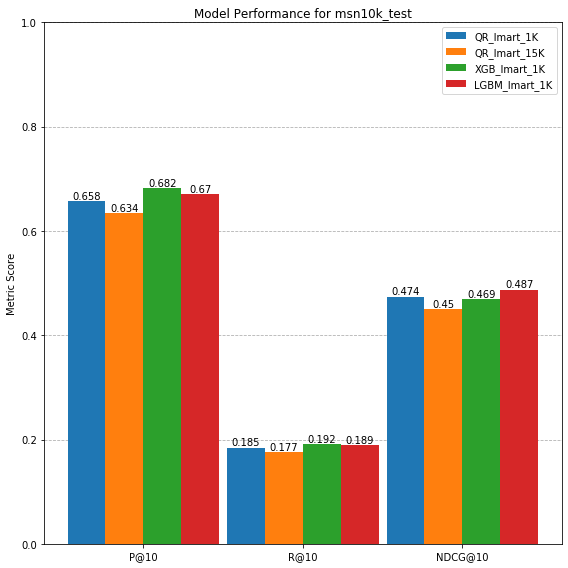

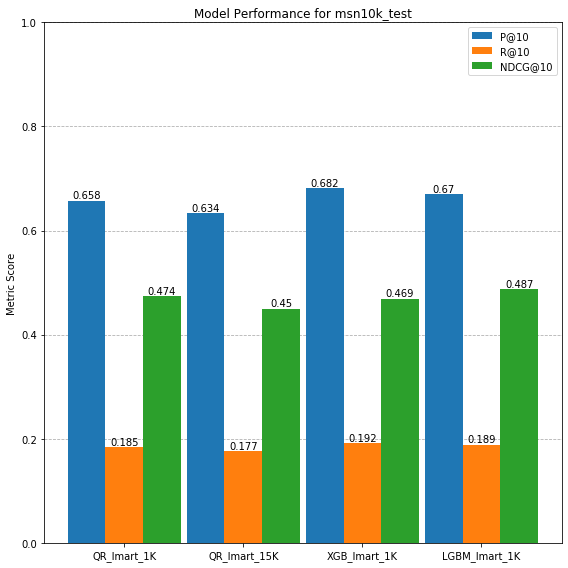

In [9]:
from rankeval.visualization.effectiveness import plot_model_performance

fig1_list = plot_model_performance(msn_model_perf, compare="models",  show_values=True)
fig2_list = plot_model_performance(msn_model_perf, compare="metrics", show_values=True)

##  2. Tree-Wise Performance

RankEval provides the possibility to evaluate different effectiveness metrics incrementally by varying the number of trees in the model, i.e., top-k trees. This may be usefull for finding the “optimal” model size, e.g., by evaluating the overfitting effect on a validation set.

Firstly, we call the **tree_wise_performance** analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the tree_wise_performance analysis by simply converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling tree-wise performance analysis

In [10]:
from rankeval.analysis.effectiveness import tree_wise_performance

# compare validation vs. test, discuss overfitting
msn_tree_wise_perf = tree_wise_performance(datasets=[msn_train, msn_validation, msn_test], 
                                          models=[msn_qr_lmart_1Ktrees, msn_xgb_lmart_1Ktrees],
                                          metrics=[precision_10, recall_10, ndcg_10],
                                          step=10)
msn_tree_wise_perf.to_dataframe()

IntProgress(value=0, description='Computing metrics', max=1800)

Tree-Wise Performance
dataset      model        k    metric                        
msn10k_train QR_lmart_1K  10   P@10                  0.613687
                               R@10                  0.177030
                               NDCG@10               0.411496
                          20   P@10                  0.629054
                               R@10                  0.182568
                               NDCG@10               0.430456
                          30   P@10                  0.637954
                               R@10                  0.185290
                               NDCG@10               0.443721
                          40   P@10                  0.643954
                               R@10                  0.187455
                               NDCG@10               0.455090
                          50   P@10                  0.648204
                               R@10                  0.187509
                               NDCG@10               0.462648
                          60   P@10                  0.651587
                               R@10                  0.188425
                               NDCG@10               0.468694
                          70   P@10                  0.653920
                               R@10                  0.189194
                               NDCG@10               0.473577
                          80   P@10                  0.655987
                               R@10                  0.190260
                               NDCG@10               0.477704
                          90   P@10                  0.657537
                               R@10                  0.190621
                               NDCG@10               0.481074
                          100  P@10                  0.658820
                               R@10                  0.190976
                               NDCG@10               0.483830
...                                                       ...
msn10k_test  XGB_lmart_1K 910  P@10                  0.683394
                               R@10                  0.191987
                               NDCG@10               0.469034
                          920  P@10                  0.683094
                               R@10                  0.191695
                               NDCG@10               0.468893
                          930  P@10                  0.682794
                               R@10                  0.191737
                               NDCG@10               0.469277
                          940  P@10                  0.683194
                               R@10                  0.192026
                               NDCG@10               0.469512
                          950  P@10                  0.682944
                               R@10                  0.192000
                               NDCG@10               0.469536
                          960  P@10                  0.682694
                               R@10                  0.191923
                               NDCG@10               0.469497
                          970  P@10                  0.682844
                               R@10                  0.191931
                               NDCG@10               0.469750
                          980  P@10                  0.682694
                               R@10                  0.191919
                               NDCG@10               0.469622
                          990  P@10                  0.682244
                               R@10                  0.191888
                               NDCG@10               0.469471
                          1000 P@10                  0.682194
                               R@10                  0.191817
                               NDCG@10               0.469309

[1800 rows x 1 columns]

#### -> Plot results

The **plot_tree_wise_performance** method helps visualize the **tree_wise_performance** analysis results in the form of a plot. It takes as input:
 - tree_wise_model_performance xarray: the tree_wise_model_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s).
 - compare: allows the user to compare models, metrics and datasets. Accepted values are "datasets", "models" or "metrics".
 
The black circle on the plotted line indicates the maximum value achieved by the metric for each model on each dataset. It is a good indicator of when the model reaches stability.    

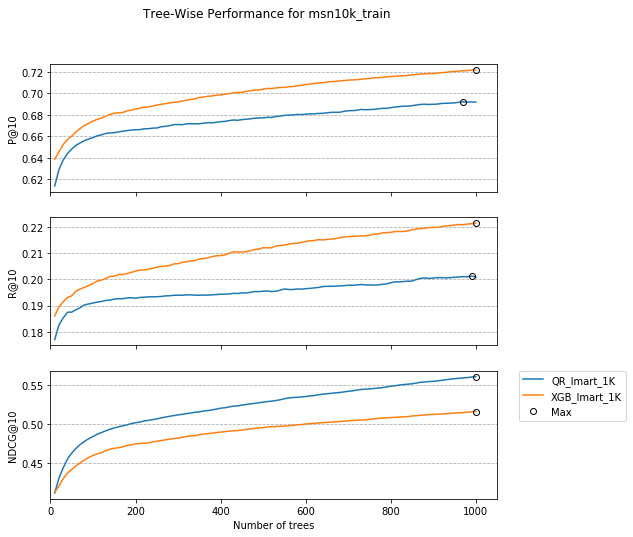

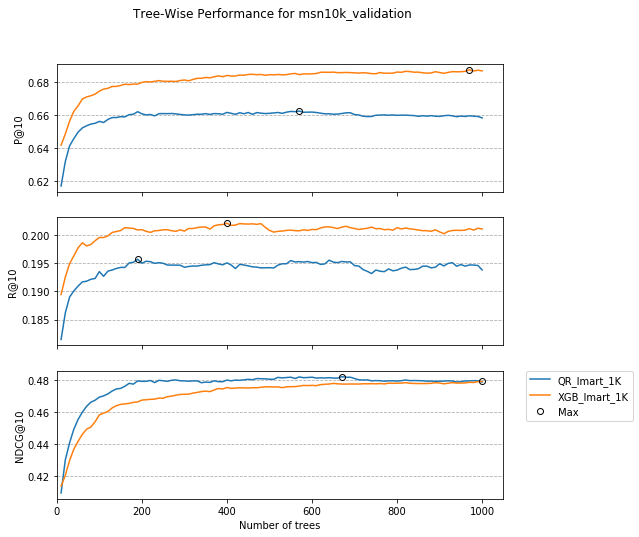

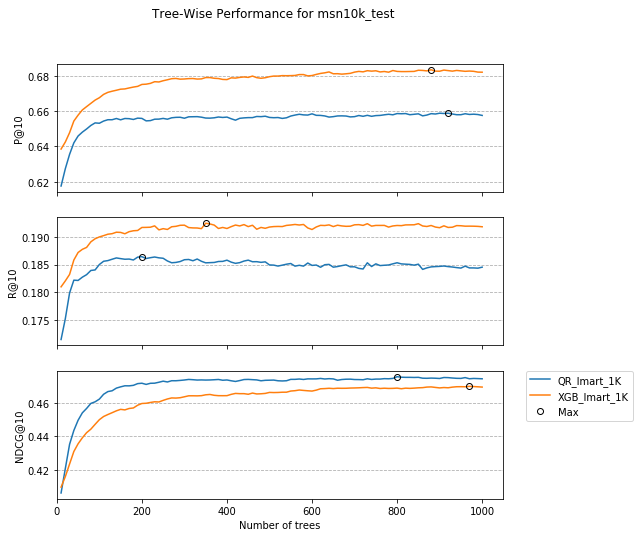

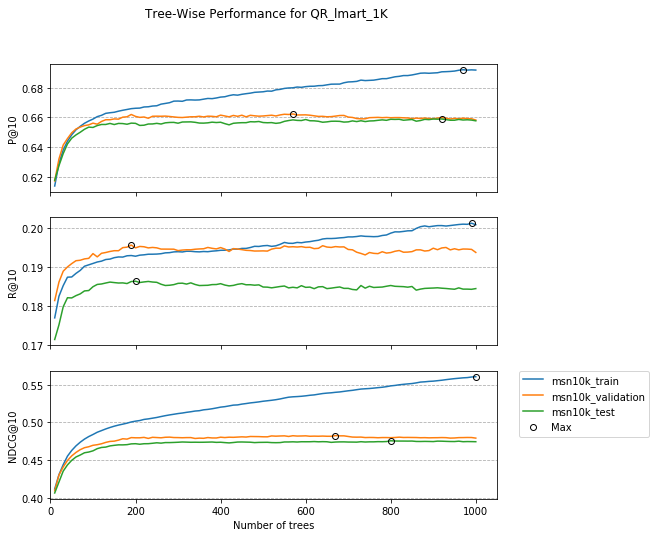

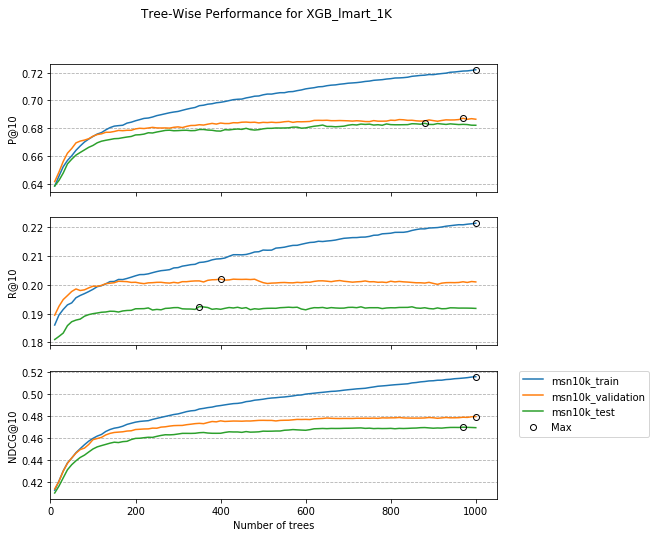

In [11]:
from rankeval.visualization.effectiveness import plot_tree_wise_performance

fig1_list = plot_tree_wise_performance(msn_tree_wise_perf, compare = "models") 
fig2_list = plot_tree_wise_performance(msn_tree_wise_perf, compare = "datasets")

## 3. Tree-Wise Average Contribution

RankEval allows to measure the contribution of each single tree to the global model accuracy independently of their order in the forest. This may  allow to reduce the size of the forest by identifying subsets of trees to prune since their contribution to the model is limited.

Firstly, we call the **tree_wise_average_contribution** analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the tree_wise_average_contribution analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Computes tree-wise average contribution analysis

In [12]:
from rankeval.analysis.effectiveness import tree_wise_average_contribution

msn_tree_contrib = tree_wise_average_contribution(datasets=[msn_validation, msn_test], 
                           models=[msn_lgbm_lmart_1Ktrees, msn_qr_lmart_1Ktrees])
msn_tree_contrib

<xarray.DataArray 'Tree-Wise Average Contribution' (dataset: 2, model: 2, trees: 1000)>
array([[[4.421792e-03, 6.992886e-03, ..., 9.295074e-05, 1.019026e-04],
        [3.713444e-02, 8.027103e-02, ..., 2.446437e-03, 1.129306e-03]],

       [[4.458845e-03, 6.990350e-03, ..., 8.670842e-05, 1.026136e-04],
        [3.752245e-02, 8.130841e-02, ..., 2.395663e-03, 1.063248e-03]]],
      dtype=float32)
Coordinates:
  * dataset  (dataset) object msn10k_validation msn10k_test
  * model    (model) object LGBM_lmart_1K QR_lmart_1K
  * trees    (trees) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

#### -> Plot results

The **plot_tree_wise_average_contribution** method helps visualize the **tree_wise_average_contribution** analysis results in the form of a plot. It takes as input:
 - tree_wise_average_contribution xarray: the tree_wise_average_contribution analysis results for a given combinations of: dataset(s) and model(s).

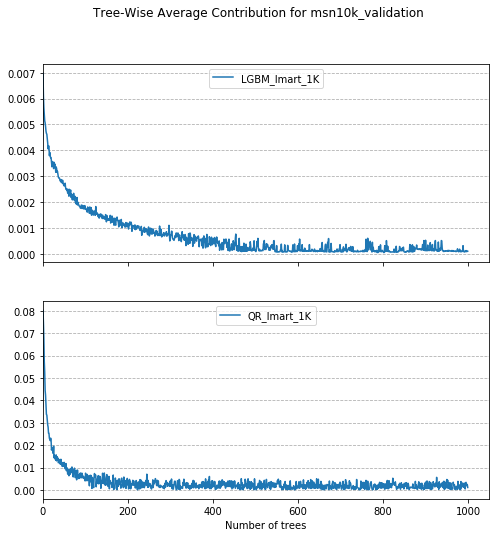

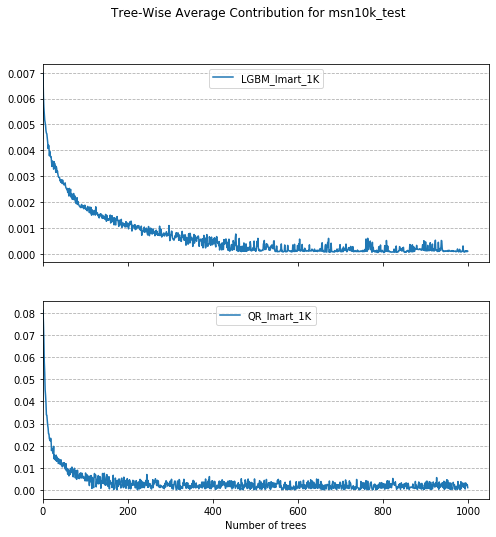

In [13]:
from rankeval.visualization.effectiveness import plot_tree_wise_average_contribution

fig_list = plot_tree_wise_average_contribution(msn_tree_contrib)

## 4. Query-Wise Performance

RankEval allows to compute the cumulative distribution of a given performance metric, e.g., fraction of queries with a NDCG score smaller than any given threshold τ , over a specific set of queries.

Firstly, we call the **query_wise_performance** analysis and pass as parameters the **datasets, models and metrics** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the query_wise_performance analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Computes query wise performance analysis

In [14]:
from rankeval.analysis.effectiveness import query_wise_performance

msn_query_wise_perf = query_wise_performance(datasets=[msn_test], 
                            models=[msn_qr_lmart_1Ktrees, msn_lgbm_lmart_1Ktrees], 
                            metrics=[precision_10, recall_10, ndcg_10],
                            bins=50)
msn_query_wise_perf

<xarray.DataArray 'Query-Wise Performance' (dataset: 1, model: 2, metric: 3, bin: 50)>
array([[[[0.0555, ..., 1.    ],
         ...,
         [0.0195, ..., 1.    ]],

        [[0.0545, ..., 1.    ],
         ...,
         [0.019 , ..., 1.    ]]]], dtype=float32)
Coordinates:
  * dataset  (dataset) object msn10k_test
  * model    (model) object QR_lmart_1K LGBM_lmart_1K
  * metric   (metric) object P@10 R@10 NDCG@10
  * bin      (bin) float64 0.02 0.04 0.06 0.08 0.1 ... 0.92 0.94 0.96 0.98 1.0

#### -> Plot results

The **plot_query_wise_performance** method helps visualize the **query_wise_performance** analysis results in the form of a plot. It takes as input:
 - tree_wise_model_performance xarray: the tree_wise_model_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s).
 - compare: allows the user to compare models, metrics and datasets. Accepted values are "models" or "metrics".

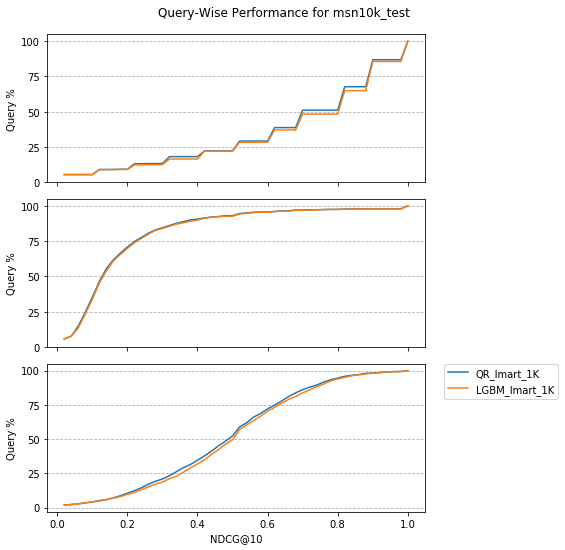

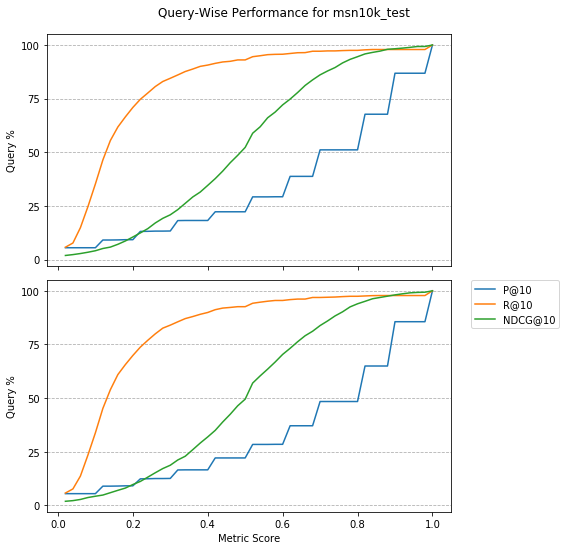

In [15]:
from rankeval.visualization.effectiveness import plot_query_wise_performance

fig1_list = plot_query_wise_performance(msn_query_wise_perf, compare="models")
fig2_list = plot_query_wise_performance(msn_query_wise_perf, compare="metrics")

## 5. Document Graded Relevance

For each document relevance class RankEval allows the evaluation of the cumulative predicted score distribution. For each relevance label available in the data, RankEval renders one curve detailing for each possible document score the fraction of documents with a smaller predicted score. The bigger the distance amongst curves the larger the model's discriminative power.

Firstly, we call the **document_graded_relevance** analysis and pass as parameters the **datasets and models** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the rank_confusion_matrix analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling document graded relevance analysis

In [16]:
from rankeval.analysis.effectiveness import document_graded_relevance

msn_doc_graded_rel = document_graded_relevance(datasets=[msn_test], 
                                models=[msn_qr_lmart_1Ktrees, msn_lgbm_lmart_1Ktrees],  
                                bins=50)
print (msn_doc_graded_rel)

<xarray.DataArray 'Document Graded Relevance' (dataset: 1, model: 2, label: 5, bin: 50)>
array([[[[8.815233e-05, ..., 1.000000e+00],
         ...,
         [0.000000e+00, ..., 1.000000e+00]],

        [[0.000000e+00, ..., 1.000000e+00],
         ...,
         [0.000000e+00, ..., 1.000000e+00]]]], dtype=float32)
Coordinates:
  * dataset  (dataset) object msn10k_test
  * model    (model) object QR_lmart_1K LGBM_lmart_1K
  * label    (label) float32 0.0 1.0 2.0 3.0 4.0
  * bin      (bin) float64 -5.664 -5.418 -5.172 -4.926 ... 5.886 6.132 6.378


#### -> Plot results

The **plot_document_graded_relevance** method helps visualize the **document_graded_relevance** analysis results in the form of a plot. It takes as input:
 - document_graded_relevance xarray: the document_graded_relevance analysis results for a given combinations of: dataset(s), model(s) and metric(s).

[<Figure size 576x576 with 2 Axes>]

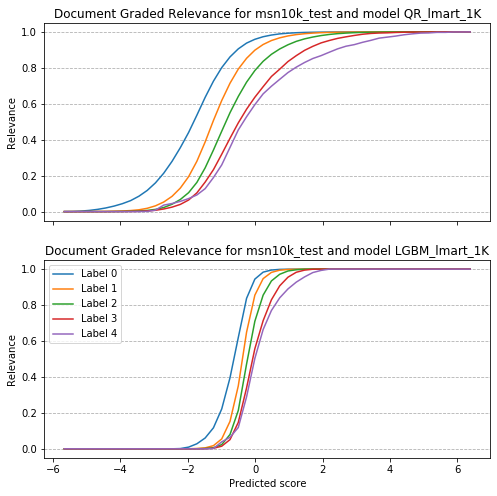

In [17]:
from rankeval.visualization.effectiveness import plot_document_graded_relevance

plot_document_graded_relevance(msn_doc_graded_rel)
# add mart model

## 6. Rank-Confusion Matrix

RankEval allows for a novel rank-oriented confusion matrix by reporting for any given relevance label l<sub>i</sub>, the number of documents with a predicted score smaller than documents with label l<sub>j</sub>. When l<sub>i</sub> > l<sub>j</sub> this corresponds to the number of mis-ranked document pairs. This can be considered as a breakdown over the relevance labels of the ranking e ectiveness of the model.

Firstly, we call the **rank_confusion_matrix** analysis and pass as parameters the **datasets and models** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the rank_confusion_matrix analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling rank confusion matrix analysis

In [18]:
from rankeval.analysis.effectiveness import rank_confusion_matrix

msn_confusion_matrix = rank_confusion_matrix(datasets=[msn_test], 
                                models=[msn_qr_lmart_1Ktrees, msn_lgbm_lmart_1Ktrees])
msn_confusion_matrix

<xarray.DataArray 'Rank Confusion Matrix' (dataset: 1, model: 2, label_i: 5, label_j: 5)>
array([[[[5632754, 3376248, 1463147,  214617,   94542],
         [2316780, 2609104, 1202629,  181616,   85945],
         [ 648287,  794693,  550606,   73137,   24667],
         [  64341,   81156,   49538,   17013,    5933],
         [  22419,   35025,   14212,    4462,   11773]],

        [[5632754, 3445088, 1502205,  218169,   95453],
         [2247940, 2609104, 1218515,  183600,   86659],
         [ 609229,  778807,  550606,   73432,   24773],
         [  60789,   79172,   49243,   17013,    5904],
         [  21508,   34311,   14106,    4491,   11773]]]], dtype=int32)
Coordinates:
  * dataset  (dataset) object msn10k_test
  * model    (model) object QR_lmart_1K LGBM_lmart_1K
  * label_i  (label_i) int32 0 1 2 3 4
  * label_j  (label_j) int32 0 1 2 3 4

#### -> Plot results

The **plot_rank_confusion_matrix** method helps visualize the **rank_confusion_matrix** analysis results in the form of a plot. It takes as input:
 - rank_confusion_matrix xarray: the rank_confusion_matrix analysis results for a given combinations of: dataset(s), model(s) and metric(s).

[<Figure size 576x576 with 2 Axes>]

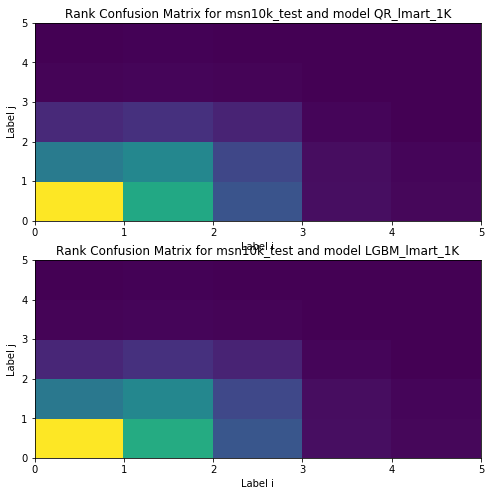

In [19]:
from rankeval.visualization.effectiveness import plot_rank_confusion_matrix

plot_rank_confusion_matrix(msn_confusion_matrix) 

## 7. Query-Class Performance

RankEval complements the feature above with a comprehensive analysis of the e ectiveness of a given model by providing a breakdown of the performance over a query classi cation. Whenever query class information is given, e.g., nav- igational, informational, transactional, number of terms composing the query, etc., RankEval provides a complete analysis of the model e ectiveness over such classes.  is analysis is extremely impor- tant especially in a production environment, as it allows to be er calibrate the ranking infrastructure w.r.t a speci c context.

Firstly, we call the **query_class_performance** analysis and pass as parameters the **datasets and models** we want to see results for. The method returns a xarray.DataArray data structure containing all the computed information. We can visualize results for the rank_confusion_matrix analysis by simply calling it or converting it to a pandas dataframe.

To better visualize the results we offer plotting facilities.

#### -> Calling query class performance analysis

In [20]:
from rankeval.analysis.effectiveness import query_class_performance

classes = ['A', 'B', 'C', 'D', 'E']
query_classes = np.array([[classes[np.random.randint(len(classes))] 
                           for _ in range(msn_test.n_queries)]])

msn_query_class_perf = query_class_performance(datasets=[msn_test], 
                                 models=[msn_qr_lmart_1Ktrees, msn_lgbm_lmart_1Ktrees],
                                 metrics=[precision_10, recall_10, ndcg_10],
                                 query_classes=query_classes)
msn_query_class_perf

<xarray.DataArray 'Query Class Performance' (dataset: 1, model: 2, metric: 3, classes: 5)>
array([[[[0.632796, 0.662206, 0.669814, 0.653995, 0.66767 ],
         [0.208888, 0.182626, 0.180657, 0.168053, 0.183125],
         [0.47369 , 0.476435, 0.473508, 0.461359, 0.485768]],

        [[0.650244, 0.672425, 0.677747, 0.673325, 0.675151],
         [0.21324 , 0.185393, 0.18852 , 0.173176, 0.185076],
         [0.493753, 0.486754, 0.484234, 0.479194, 0.493198]]]], dtype=float32)
Coordinates:
  * dataset  (dataset) object msn10k_test
  * model    (model) object QR_lmart_1K LGBM_lmart_1K
  * metric   (metric) object P@10 R@10 NDCG@10
  * classes  (classes) <U1 'A' 'B' 'C' 'D' 'E'

#### -> Plot results

The **plot_query_class_performance** method helps visualize the **query_class_performance** analysis results in the form of a plot. It takes as input: 
 - query_class_performance xarray: the query_class_performance analysis results for a given combinations of: dataset(s), model(s) and metric(s). 
 - compare: allows the user to compare models or metrics. Accepted values are "models" or "metrics".
 - show values: allows the user to show the actual values on the plotted bars.

[<Figure size 576x576 with 3 Axes>]

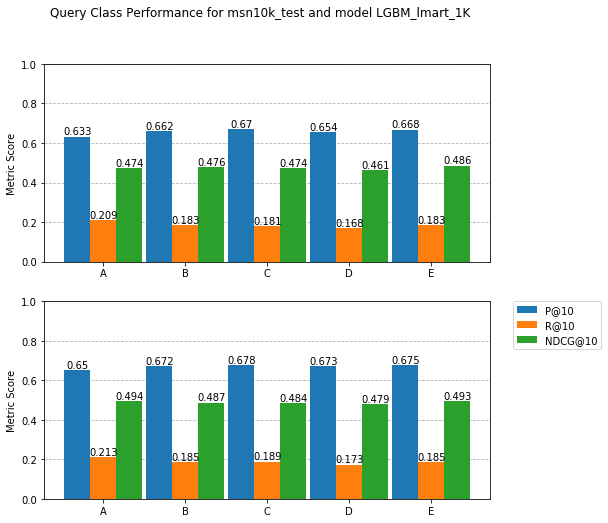

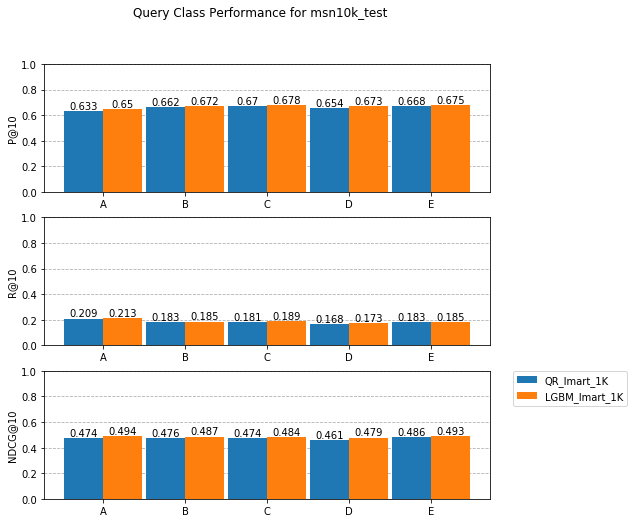

In [21]:
from rankeval.visualization.effectiveness import plot_query_class_performance

plot_query_class_performance(msn_query_class_perf, compare="metrics", show_values = True)
plot_query_class_performance(msn_query_class_perf, compare="models", show_values = True)